# Disclaimer & Attribution

This notebook is generated by Gemini 3. The overall conceptual design, correctness verification, and minor modifications are contributed by Tevfik Aytekin.

## Bayesian Personalized Ranking (BPR)

Unlike explicit feedback (e.g., 1-5 star ratings) where the goal is to predict the exact rating a user would give to an item, implicit feedback (e.g., clicks, purchase history, view times) deals with binary or frequency data indicating interaction. In implicit feedback settings, the absence of an interaction does not necessarily mean dislike; it simply means we haven't observed a preference. Therefore, the goal shifts from rating prediction to **ranking items** based on predicted user preference.

**Bayesian Personalized Ranking (BPR)** is a generic optimization criterion for personalized ranking that is the state-of-the-art for implicit feedback. Instead of looking at a single user-item pair, BPR optimizes for the correct ranking of pairs of items for a user. It assumes that a user prefers an observed item $i$ over an unobserved item $j$.

#### Mathematical Formulation

The BPR objective aims to maximize the posterior probability that a user $u$ prefers item $i$ over item $j$. The optimization problem is often framed as minimizing the negative log-likelihood.

The BPR loss function is defined as:

$$
L_{BPR} = - \sum_{(u, i, j) \in D_S} \ln \sigma(\hat{x}_{uij}) + \lambda_{\Theta} ||\Theta||^2
$$

Where:
- $D_S$: The set of triples $(u, i, j)$ where user $u$ interacted with item $i$ (positive) but not item $j$ (negative).
- $\sigma(x) = \frac{1}{1 + e^{-x}}$ is the sigmoid function.
- $\hat{x}_{uij} = \hat{x}_{ui} - \hat{x}_{uj}$ captures the difference in predicted scores between the positive item $i$ and negative item $j$. For Matrix Factorization, $\hat{x}_{ui} = w_u^T h_i$.
- $\lambda_{\Theta} ||\Theta||^2$ is the regularization term to prevent overfitting.

Intuitively, minimizing this loss encourages the score of the positive item $\hat{x}_{ui}$ to be significantly larger than the score of the negative item $\hat{x}_{uj}$.

### Negative Sampling

In implicit feedback datasets, we typically only have "positive" samples (observed interactions). To train a model like BPR, we need examples of what the user *doesn't* prefer (or prefers less). Since enumerating all unobserved items is computationally expensive and potentially inaccurate (some unobserved items might actually be liked), we use **Negative Sampling**.

For every positive interaction $(u, i)$, we randomly sample one or more items $j$ that user $u$ has not interacted with. These form the negative samples used to update the model weights, teaching the model to rank observed interactions higher than unobserved ones.

## Update Data Loading for ML-1M


In [ ]:
import os
import urllib.request
import zipfile
import pandas as pd

url = 'https://files.grouplens.org/datasets/movielens/ml-1m.zip'
filename = 'ml-1m.zip'

# Download the file if it does not already exist
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)
    print(f"Downloaded {filename}")

# Extract the contents of the zip file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('.')
print("Extracted dataset")

# Load the data from 'ml-1m/ratings.dat'
columns = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('ml-1m/ratings.dat', sep='::', names=columns, engine='python')
print("Data loaded successfully")

# Display the first few rows
df.head()

Downloaded ml-1m.zip
Extracted dataset
Data loaded successfully


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## Preprocess 1M Data

Preprocess the MovieLens 1M data by re-indexing IDs, creating user history, and splitting into train/test sets.


In [ ]:
from sklearn.model_selection import train_test_split

# 1. Re-index user_id and item_id to contiguous integers
user_ids = df['user_id'].unique()
item_ids = df['item_id'].unique()

user2idx = {u: i for i, u in enumerate(user_ids)}
item2idx = {i: idx for idx, i in enumerate(item_ids)}

df['user_id'] = df['user_id'].map(user2idx)
df['item_id'] = df['item_id'].map(item2idx)

# 2. Calculate and store total number of unique users and items
num_users = len(user_ids)
num_items = len(item_ids)
print(f"Total unique users: {num_users}")
print(f"Total unique items: {num_items}")

# 3. Create user_history dictionary (All interactions for negative sampling)
user_history = df.groupby('user_id')['item_id'].apply(set).to_dict()

# 4. Perform 80/20 Train/Test Split
# Randomly split the interactions
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 5. Reset indices
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# 6. Print the number of records
print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
train_df.head()

Total unique users: 6040
Total unique items: 3706
Train samples: 800167
Test samples: 200042


,user_id,item_id,rating,timestamp
0,2506,76,2,974076680
1,4086,897,4,965431652
2,18,151,3,978146863
3,4117,7,4,965804599
4,2906,518,4,971838472


## Train Model on 1M Data

Train the Matrix Factorization model on the preprocessed MovieLens 1M dataset.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time

# Define Matrix Factorization Model
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64):
        super(MatrixFactorization, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)

    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        element_product = (user_emb * item_emb).sum(dim=1)
        return element_product

# Helper function for negative sampling (Manual Batching)
def sample_negatives_batch(users, num_items, user_history):
    # Optimistically sample random items
    neg_items = np.random.randint(0, num_items, size=len(users))

    # Resample conflicts (collisions with user history)
    for idx, u in enumerate(users):
        while neg_items[idx] in user_history[u]:
            neg_items[idx] = np.random.randint(0, num_items)
    return neg_items


# Evaluation Function (Updated to Per-User Metrics)
def evaluate(model, test_df, train_user_history, top_k=10):
    model.eval()
    hr_list = []
    ndcg_list = []

    # Group test items by user
    test_user_items = test_df.groupby('user_id')['item_id'].apply(list).to_dict()
    all_item_emb = model.item_embedding.weight

    with torch.no_grad():
        for u, gt_items in test_user_items.items():
            # gt_items is a list of all items in the test set for this user
            gt_items = np.array(gt_items)

            u_tensor = torch.tensor([u], device=device)
            u_emb = model.user_embedding(u_tensor)

            # Score all items
            scores = torch.matmul(u_emb, all_item_emb.t()).squeeze()


            # Mask items seen in training
            seen_items = list(train_user_history.get(u, []))
            if seen_items:
                scores[seen_items] = -float('inf')

            # Get Top K indices
            _, top_indices = torch.topk(scores, top_k)
            top_indices = top_indices.cpu().numpy()

            # --- HR @ K (Per User) ---
            # Check if ANY of the top_k items are in the user's test set
            hits = np.intersect1d(top_indices, gt_items)
            if len(hits) > 0:
                hr_list.append(1)
            else:
                hr_list.append(0)

            # --- NDCG @ K (Per User) ---
            # Relevance vector: 1 if item is in test set, 0 otherwise
            relevance = np.isin(top_indices, gt_items).astype(float)

            # DCG
            dcg = np.sum(relevance / np.log2(np.arange(2, top_k + 2)))

            # IDCG
            n_relevant = min(len(gt_items), top_k)
            ideal_relevance = np.zeros(top_k)
            ideal_relevance[:n_relevant] = 1.0
            idcg = np.sum(ideal_relevance / np.log2(np.arange(2, top_k + 2)))

            if idcg > 0:
                ndcg_list.append(dcg / idcg)
            else:
                ndcg_list.append(0)

    return np.mean(hr_list), np.mean(ndcg_list)

In [ ]:
# Instantiate Model and Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = MatrixFactorization(num_users, num_items, embedding_dim=64)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

#  Preparation for Training
# Create train_user_history for masking seen items during evaluation
train_user_history = train_df.groupby('user_id')['item_id'].apply(set).to_dict()

# Prepare arrays for manual batching
users_train = train_df['user_id'].values
items_train = train_df['item_id'].values
num_samples = len(users_train)
batch_size = 2048
num_epochs = 10

# Training Loop with Manual Batching
print("Starting training on MovieLens 1M with Manual Batching...")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    start_time = time.time()

    # Shuffle training data
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    # Iterate in batches
    num_batches = 0
    for i in range(0, num_samples, batch_size):
        batch_indices = indices[i:i+batch_size]

        batch_users = users_train[batch_indices]
        batch_pos_items = items_train[batch_indices]

        # Manual Negative Sampling
        batch_neg_items = sample_negatives_batch(batch_users, num_items, user_history)

        # Convert to tensors
        u = torch.LongTensor(batch_users).to(device)
        i = torch.LongTensor(batch_pos_items).to(device)
        j = torch.LongTensor(batch_neg_items).to(device)

        optimizer.zero_grad()

        # Forward pass
        pos_scores = model(u, i)
        neg_scores = model(u, j)

        # BPR Loss
        loss = -torch.mean(torch.log(torch.sigmoid(pos_scores - neg_scores)))
        # You can also try the following losses and see the result
        #loss = -torch.mean(torch.sigmoid(pos_scores - neg_scores))
        #loss = -torch.mean(torch.log(pos_scores - neg_scores))
        #loss = -torch.mean(pos_scores - neg_scores)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    avg_loss = total_loss / num_batches

    # Evaluate using the updated Per-User function
    hr, ndcg = evaluate(model, test_df, train_user_history, top_k=10)

    elapsed = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - HR@10: {hr:.4f} - NDCG@10: {ndcg:.4f} - Time: {elapsed:.2f}s")

Using device: cuda
Starting training on MovieLens 1M with Manual Batching...
Epoch 1/10 - Loss: 0.5255 - HR@10: 0.6761 - NDCG@10: 0.2050 - Time: 6.08s
Epoch 2/10 - Loss: 0.3421 - HR@10: 0.6752 - NDCG@10: 0.2099 - Time: 4.95s
Epoch 3/10 - Loss: 0.3256 - HR@10: 0.6867 - NDCG@10: 0.2194 - Time: 4.93s
Epoch 4/10 - Loss: 0.3078 - HR@10: 0.7110 - NDCG@10: 0.2337 - Time: 4.91s
Epoch 5/10 - Loss: 0.2945 - HR@10: 0.7168 - NDCG@10: 0.2481 - Time: 4.87s
Epoch 6/10 - Loss: 0.2843 - HR@10: 0.7322 - NDCG@10: 0.2575 - Time: 4.94s
Epoch 7/10 - Loss: 0.2763 - HR@10: 0.7436 - NDCG@10: 0.2659 - Time: 4.91s
Epoch 8/10 - Loss: 0.2694 - HR@10: 0.7491 - NDCG@10: 0.2740 - Time: 4.93s
Epoch 9/10 - Loss: 0.2640 - HR@10: 0.7547 - NDCG@10: 0.2796 - Time: 4.88s
Epoch 10/10 - Loss: 0.2596 - HR@10: 0.7653 - NDCG@10: 0.2872 - Time: 4.84s


### Discussion: Why BPR Loss over Linear Difference?

**Question:** Why not use the simpler loss function `loss = -mean(pos_scores - neg_scores)`?

**1. Linear Loss (`-x`)**
*   **Formula:** $L = -(Score_{pos} - Score_{neg})$
*   **Gradient:** The gradient is always $-1$, regardless of how correct the model is.
*   **Problem:** The model **never stops pushing**. Even if $Score_{pos} = 100$ and $Score_{neg} = 0$, the model still tries to make the gap bigger with the same intensity. This wastes optimization effort on "easy" pairs that are already correctly ranked, potentially distracting the model from fixing difficult errors.

**2. BPR Loss (`-ln(sigmoid(x))`)**
*   **Formula:** $L = -\ln(\sigma(Score_{pos} - Score_{neg}))$
*   **Gradient:** The gradient is adaptive. It is large when the model is wrong ($Pos < Neg$) and small when the model is right ($Pos > Neg$).
*   **Benefit:** It has **diminishing returns**. Once the model is confident that the user prefers the positive item (e.g., $P(Pos > Neg) \approx 1$), the gradient drops to $0$. The model "stops worrying" about this pair and focuses its learning updates on the hard cases where it is still making mistakes.

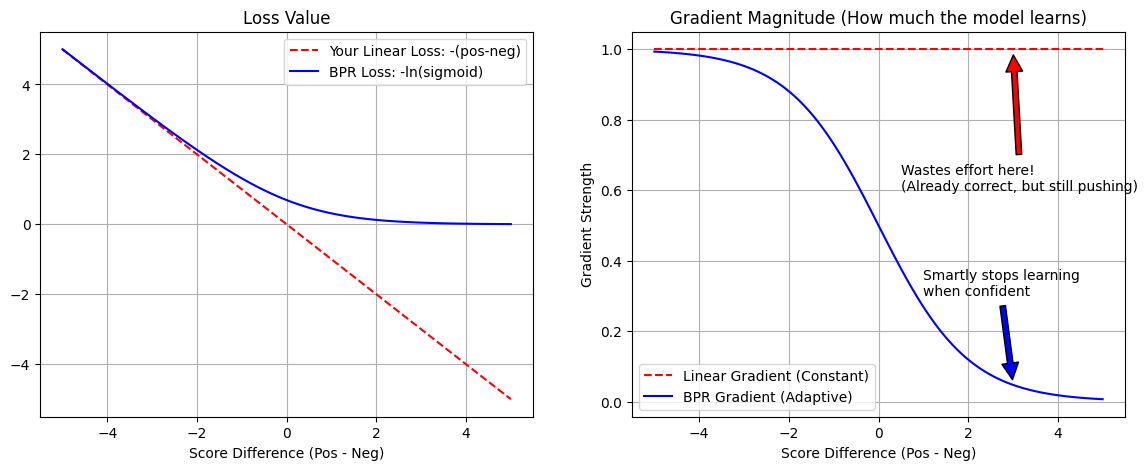

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-5, 5, 100)

# 1. Your Linear Loss: -(pos - neg) = -x
loss_linear = -x
# Gradient is always -1
grad_linear = np.full_like(x, -1)

# 2. BPR Loss: -ln(sigmoid(x))
loss_bpr = -np.log(1 / (1 + np.exp(-x)))
# Gradient goes to 0 as x increases
grad_bpr = (1 / (1 + np.exp(-x))) - 1

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
ax[0].plot(x, loss_linear, label='Your Linear Loss: -(pos-neg)', color='red', linestyle='--')
ax[0].plot(x, loss_bpr, label='BPR Loss: -ln(sigmoid)', color='blue')
ax[0].set_title('Loss Value')
ax[0].set_xlabel('Score Difference (Pos - Neg)')
ax[0].legend()
ax[0].grid(True)

# Plot Gradient Magnitude
ax[1].plot(x, np.abs(grad_linear), label='Linear Gradient (Constant)', color='red', linestyle='--')
ax[1].plot(x, np.abs(grad_bpr), label='BPR Gradient (Adaptive)', color='blue')
ax[1].set_title('Gradient Magnitude (How much the model learns)')
ax[1].set_xlabel('Score Difference (Pos - Neg)')
ax[1].set_ylabel('Gradient Strength')

# Annotations
ax[1].annotate('Wastes effort here!\n(Already correct, but still pushing)', xy=(3, 1), xytext=(0.5, 0.6),
             arrowprops=dict(facecolor='red', shrink=0.05))
ax[1].annotate('Smartly stops learning\nwhen confident', xy=(3, 0.05), xytext=(1, 0.3),
             arrowprops=dict(facecolor='blue', shrink=0.05))

ax[1].legend()
ax[1].grid(True)
plt.show()

### Why `torch.log` prevents Vanishing Gradients

**Question:** In the training if I remove the `torch.log` from the loss calculation the performance decreased, why is that?

**Answer:** The `torch.log` is crucial for optimization stability, specifically to **prevent vanishing gradients**.

Here is what happens:

*   **With log (BPR Loss):** The loss function behaves like a linear function for large errors. If the model makes a very bad prediction, the gradient (slope) remains constant, providing a strong signal to correct the mistake.
*   **Without log (Sigmoid only):** The gradient approaches zero if the prediction is very wrong. The model "gives up" on fixing large errors because the feedback signal becomes too weak.

The following plot visualizes the **Loss** and **Gradients** for both cases to show why learning fails without the log.

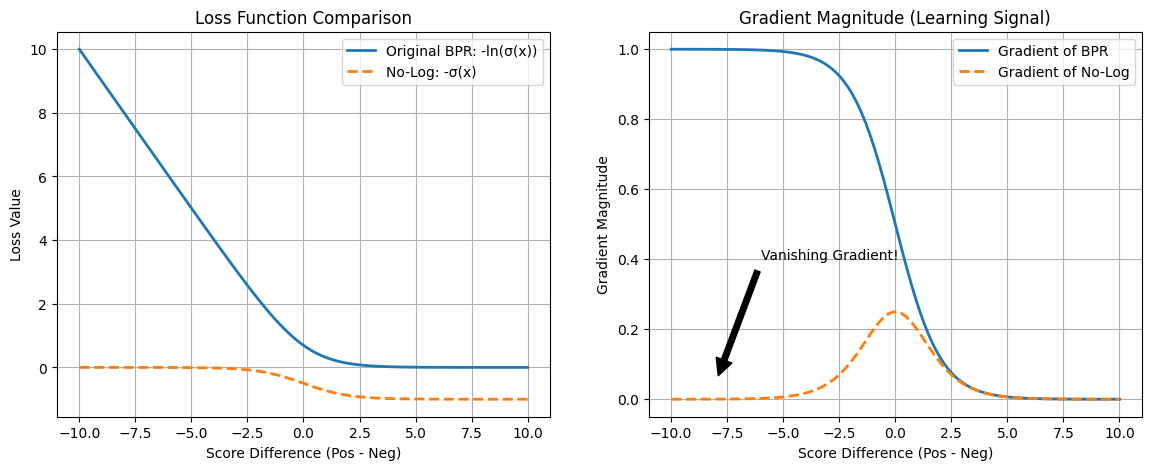

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Define the input range (difference between positive and negative scores)
x = np.linspace(-10, 10, 100)

# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 1. Original BPR Loss: -ln(sigmoid(x))
loss_bpr = -np.log(sigmoid(x))
# Gradient of BPR: sigmoid(x) - 1
grad_bpr = sigmoid(x) - 1

# 2. No-Log Loss: -sigmoid(x)
loss_no_log = -sigmoid(x)
# Gradient of No-Log: -sigmoid(x) * (1 - sigmoid(x))
grad_no_log = -sigmoid(x) * (1 - sigmoid(x))

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss Functions
ax[0].plot(x, loss_bpr, label='Original BPR: -ln(σ(x))', linewidth=2)
ax[0].plot(x, loss_no_log, label='No-Log: -σ(x)', linewidth=2, linestyle='--')
ax[0].set_title('Loss Function Comparison')
ax[0].set_xlabel('Score Difference (Pos - Neg)')
ax[0].set_ylabel('Loss Value')
ax[0].legend()
ax[0].grid(True)

# Plot Gradients
ax[1].plot(x, np.abs(grad_bpr), label='Gradient of BPR', linewidth=2)
ax[1].plot(x, np.abs(grad_no_log), label='Gradient of No-Log', linewidth=2, linestyle='--')
ax[1].set_title('Gradient Magnitude (Learning Signal)')
ax[1].set_xlabel('Score Difference (Pos - Neg)')
ax[1].set_ylabel('Gradient Magnitude')
ax[1].annotate('Vanishing Gradient!', xy=(-8, 0.05), xytext=(-6, 0.4),
             arrowprops=dict(facecolor='black', shrink=0.05))
ax[1].legend()
ax[1].grid(True)

plt.show()

### Regularization in PyTorch: `weight_decay` vs. Explicit Loss

The BPR objective is:
$$
L_{BPR} = \underset{\text{Data Loss}}{- \sum \ln \sigma(\hat{x}_{uij})} + \underset{\text{Regularization}}{\lambda_{\Theta} ||\Theta||^2}
$$

**Method 1: The PyTorch Way (Currently Used)**
We pass `weight_decay` to the optimizer. This applies L2 regularization to the gradients directly during the update step. It is computationally more efficient.
```python
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
```

**Method 2: The Explicit Way (Manual Calculation)**
If we set `weight_decay=0` in the optimizer, we would have to calculate the L2 norm manually in the loop:
```python
# 1. Data Loss
data_loss = -torch.mean(torch.log(torch.sigmoid(pos_scores - neg_scores)))

# 2. Regularization Loss (Sum of squares of all embeddings)
reg_loss = 0
for param in model.parameters():
    reg_loss += torch.sum(param ** 2)

# 3. Total Loss
lambda_reg = 1e-5
loss = data_loss + (lambda_reg * reg_loss)
```